In [62]:
import cv2
import scipy
import numpy as np
import heapq
from matplotlib import pyplot as plt
from scipy.optimize import curve_fit, basinhopping, minimize, differential_evolution, NonlinearConstraint, Bounds
from img_rec_module.sig_proc import *
from expr import *

In [63]:
x = np.random.random(5)
dotp = lambda z, x: -z@x
cons = [{'type': 'ineq',
              'fun' : lambda z: 1- np.linalg.norm(z)}]
        

res = minimize(dotp, x0=[0, 0, 0, 0,1], args=(x),constraints=cons)
z = res.x
print(np.linalg.norm(x), z, z@x)


1.3314798494623055 [0.46536693 0.42018378 0.66245756 0.2597443  0.31711531] 1.331479864312434


### Data

In [64]:
### Data
bright = "bright/img_81_1.png"
calib = "calib4/img_59_1.png"
skewed = "skewed/img_90_1.png"
ambi_series = "ambi/img_1_{0}.png"
beam_series = "ambi/img_2_{0}.png"
calib_series = "calib4/img_{0}_1.png"
skewed_series = "skewed/img_{0}_1.png"
bright_series = "bright/img_{0}_1.png"
img = cv2.imread(skewed, 0)

### Deliverable 1:  function lum_invar(img, ambi) --> yield img with low noise level
* Method 1: subtraction, gaussian_blur
* Method 2: subtraction, fourier noise filter

In [65]:
# Conversion between complex and real!!
def standard_proc_full(img):
    imgf, ishift, im = fourier_trans(img)
    lower = 0.003
    upper = 0.9998
    #naive_mask_cc = data_masked_concave(imgf, 0, lower, upper, 0, edge=False)
    # naive_mask_cc = data_masked_concave(imgf, lower, 0, 0, upper, edge=False)
    naive_mask_cc = data_masked_concave(imgf, 0, 0, upper, upper)
    inv_naive_cc = np.fft.ifft2(naive_mask_cc)
    naive_mask_cv = data_masked_convex(imgf, 0.06, 0.06, 0, 0)
    # naive_mask_cv = data_masked_concave(imgf, 0, 0, 0.9998, 0.9998)
    inv_naive_cv = np.fft.ifft2(naive_mask_cv)
    gradable = np.abs(inv_naive_cc)
    gradablecv = np.abs(inv_naive_cv)
    blur = cv2.GaussianBlur(img, (7,7), 0)
    sobelx, sobely, gradient = gradient_calc(gradable, ks=-1)
    sobelxblur, sobelyblur, gradblur = gradient_calc(blur, ks=-1)
    sobelxcv, sobelycv, gradcv = gradient_calc(gradablecv, ks=-1)
    compare_images((img, 'Raw Image'), (img_log(np.abs(np.fft.fftshift(imgf))), "Fourier"),
                   (blur, 'Gaussian Blur'),
                   (np.abs(inv_naive_cc), "Concave Masked"),
                   (np.abs(inv_naive_cv), "Convex Masked"),
                   (sobelx, "Sobel x"), (sobely, "Sobel y"),
                   (gradient, "Gradient"),
                   color_map='gray')

    r_int = 200
    c_int = 300
    dimr, dimc = img.shape
    cs = np.arange(dimc)
    rs = np.arange(dimr)
    y_s_h = np.array([sobelx.item(r_int, c) for c in cs])
    y_s_v = np.array([sobely.item(r, c_int) for r in rs])
    y_s_h_b = np.array([sobelxblur.item(r_int, c) for c in cs])
    y_s_v_b = np.array([sobelyblur.item(r, c_int) for r in rs])
    y_s_h_cv = np.array([sobelxcv.item(r_int, c) for c in cs])
    y_s_v_cv = np.array([sobelycv.item(r, c_int) for r in rs])
    yhs = blur[r_int,:]
    yvs = blur[:, c_int]
    plt.figure(figsize=(20, 20))
    plt.subplot(421)
    plt.plot(cs, y_s_h, 'b-')
    plt.title("cch")
    plt.subplot(422)
    plt.plot(rs, y_s_v, 'b-')
    plt.title("ccv")
    plt.subplot(423)
    plt.plot(cs, y_s_h_b, 'b-')
    plt.title("bh")
    plt.subplot(424)
    plt.plot(rs, y_s_v_b, 'b-')
    plt.title("bv")
    plt.subplot(425)
    plt.plot(cs, y_s_h_cv, 'b-')
    plt.title("cvh")
    plt.subplot(426)
    plt.plot(rs, y_s_v_cv, 'b-')
    plt.title("cvc")
    plt.subplot(427)
    plt.plot(cs, yhs, 'b-')
    plt.title("blurh raw")
    plt.subplot(428)
    plt.plot(rs, yvs, 'b-')
    plt.title("blurv raw")
    plt.show()
    
    return y_s_h, y_s_v


#### Mask Optimization

skewed/img_90_1.png -----------------------------------
LR:0, LC:0, UR:1, UC:1
LR:28, LC:38, UR:480, UC:640


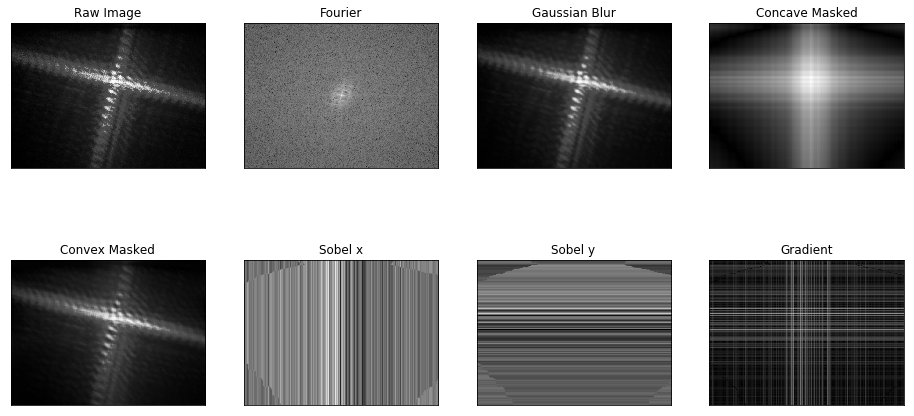

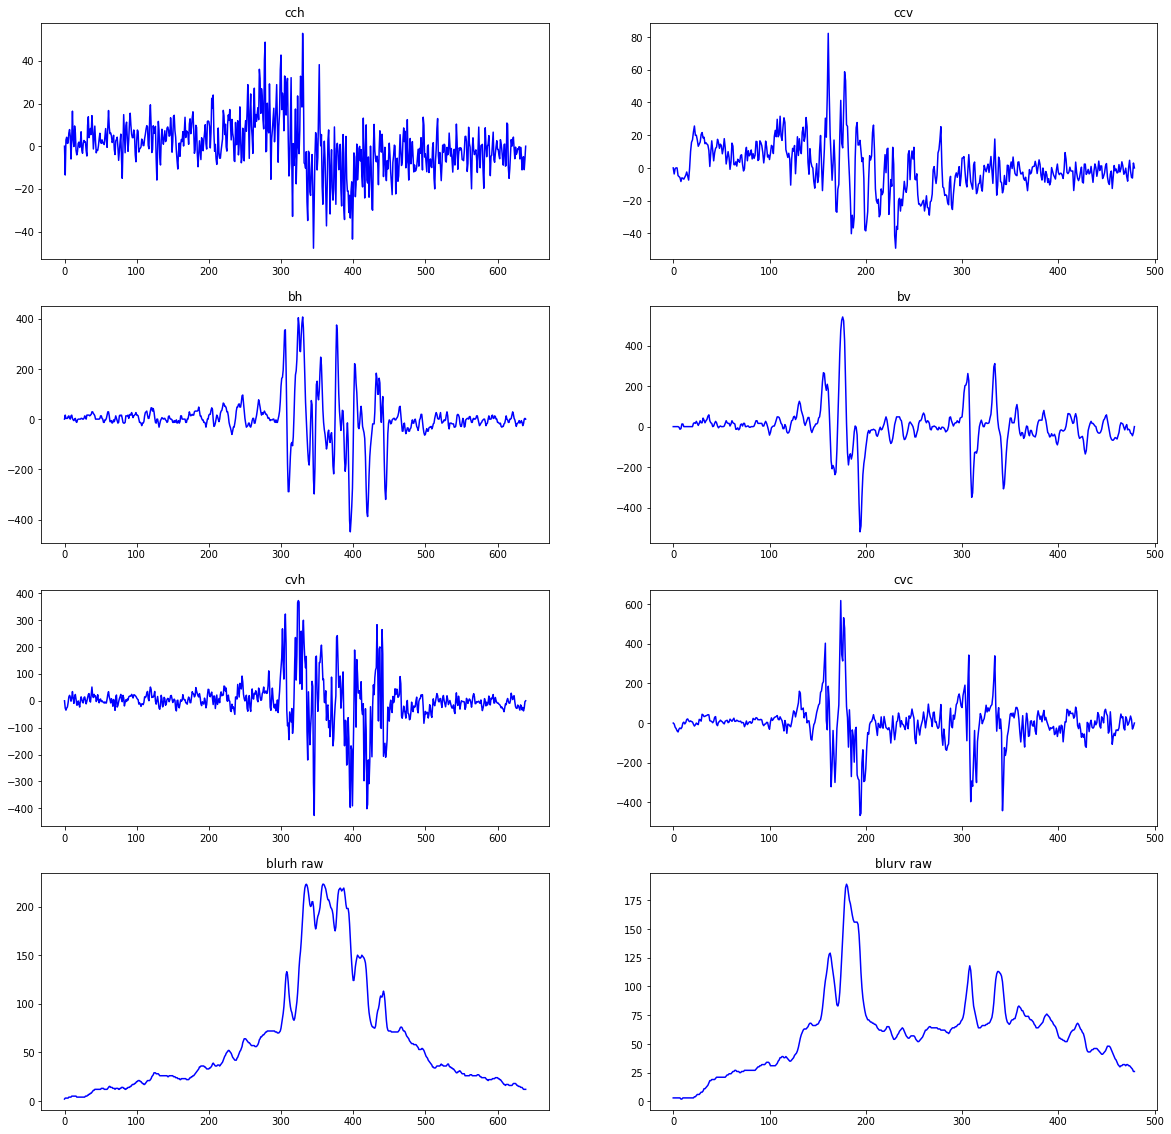

In [66]:
ns = skewed_series.format(90)
print(ns, '-----------------------------------')
img = cv2.imread(ns, 0)
y =standard_proc_full(img)

In [67]:
def lumin_invar(img, ambi):
    res = image_diff(img, ambi)
    return cv2.GaussianBlur(res, (7,7), 0)

### Deliverable 2: function gather_peaks(low_noise_img) --> yield vb_points, hb_points

#### Subproblem 1: function get_maxi_minis(array):
  * Method 1 (naive fix, satisfies objective): pluck maximum, done when get two maxis and minis
    * func $is\_extrema(x, mu, sig)$ -- returns true if $ |\frac{s[i] - \mu(a)}{\sigma(a)} | \geq \delta, \forall \ i$
    * PROCEDURE:
      * loop [data] and store maxis and minis in a min-heap and max-heap with size-ceiling $t$
      * sort data in locational order $L$ as well as gradient magnitude order $G$, latter stored in two queues
      * loop through two queues and pluck the edge $\rightarrow$ store $edge\_method(m, n)$
    
  * Method 2 (complicated challenge): given array $a$ generate a global maxi-mini streams $s$ that would satisfy $$ |
  \frac{s[i] - \mu(a)}{\sigma(a)} | \geq \delta, \forall \ i$$ where $\delta$ is an extrema threshold.
  
#### Subproblem 2: fit_gaussian
  * method 1: slice by slice traversal -- CURRENT
  * method 2: fit by $$I(x, y) = A e^{c(x - \frac {r - y sin\theta} {cos\theta})}$$
  
#### Insights:
  * When trying to have two different ordering point to each other; first sort order in order $A(i, *)$ and store these tuples and sort in order $B(i) \rightarrow A[*] = ind_B(i)$

In [68]:
def gather_all(imgr, sample_int=30, gk=9, ks=-1):
    dimr = imgr.shape[0]
    dimc = imgr.shape[1]
    # Image Processing
    gksize = (gk, gk)
    sigmaX = 0
    img = cv2.GaussianBlur(imgr, gksize, sigmaX)
    sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=ks)
    sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=ks)
    # Parameter Setting
    nr = sample_int
    nc = sample_int
    # Gathering Data
    centers_v = []
    centers_h = []
    while nr < dimr:
        data_x = sobelx[nr,:]
        am = gather_centers(data_x, img[nr, :], centers_v, 0, nr, gaussian_center)
        nr += sample_int
    while nc < dimc:
        data_y = sobely[:, nc]
        raw_y = img[:, nc]
        am = gather_centers(data_y, img[:, nc], centers_h, 1, nc, gaussian_center)
        nc += sample_int
    return centers_v, centers_h

def gather_centers(grad, raw_data, reserve, ax, ax_n, center_method, debug=False):
    # Given grad and raw_data, insert the possible beam centers to reserves
    max_grad, min_grad = get_maxi_mini(grad)
    max_q, min_q, locs = bi_order_sort(max_grad, min_grad)
    miu, sig = np.mean(raw_data), np.std(raw_data)
    avant = lambda locs, i: locs[i-1] if i-1 >= 0 else None
    apres = lambda locs, i: locs[i+1] if i+1 < len(locs) else None
    i = 0
    peaked = False
    while (i < 2 or peaked) and max_q and min_q:
        if peaked:
            top = min_q.pop()
            av = avant(locs, top[1])
            if av in max_q and beam_bound(raw_data, miu, sig, av, top):
                mid = center_method(grad, raw_data, av[0], top[0])
                reserve.append((ax_n, mid) if ax == 0 else (mid, ax_n))
                max_q.remove(av)
                i += 1
            peaked = False
        else:
            max_top = max_q.pop()
            min_top = min_q[0]
            if beam_bound(raw_data, miu, sig, max_top, min_top):
                #print("MaxMin: ", max_top, min_top)
                mid = center_method(grad, raw_data, max_top[0], min_top[0])
                reserve.append((ax_n, mid) if ax == 0 else (mid, ax_n))
                min_q.remove(min_top)
                i += 1
            else:
                peaked = True
                ap = apres(locs, max_top[1])
                # QUICK FIX HERE, THINK MORE
                if ap in min_q and beam_bound(raw_data, miu, sig, max_top, ap):
                    #print("Max_apres: ", max_top, ap)
                    mid = center_method(grad, raw_data, max_top[0], ap[0])
                    reserve.append((ax_n, mid) if ax == 0 else (mid, ax_n)) 
                    min_q.remove(ap)
                    i += 1
    if debug:
        keypoints = [l[0] for l in locs]
        ref1 = np.full_like(keypoints, (max(grad)+min(grad)) / 2)
        ref2 = np.full_like(keypoints, (max(raw_data)+min(raw_data)) / 2)
        plt.figure(figsize=(10, 10))
        plt.subplot(211)
        plt.plot(range(len(raw_data)), grad, 'b-')
        plt.scatter(keypoints, ref1)
        plt.title("{0} {1} Sobel".format('ROW' if ax == 0 else 'COL', ax_n))
        plt.subplot(212)
        plt.plot(range(len(raw_data)), raw_data, 'b-', range(len(raw_data)), np.full_like(grad, np.mean(raw_data) + 2 *np.std(raw_data)), 'r-')
        plt.scatter(keypoints, ref2)
        plt.title("{0} {1} IMG".format('ROW' if ax == 0 else 'COL', ax_n))
    return i
                        
                
def sup_tout(max_q, min_q, d, guess):
    if guess == 0:
        prem, deux = max_q, min_q
    else:
        prem, deux = min_q, max_q
    if d in prem:
        prem.remove(d)
    elif d in prem:
        deux.remove(d)
    else:
        raise RuntimeError("Tried to remove already removed term! {0}, {1}".format(d, guess))

def get_maxi_mini(data, ceil=3):
    # Given data, pluck the maxis and minis and store them in minpq and maxpq respectively
    max_grad = []
    min_grad = []
    nat_select = lambda a, b: a if a[0] >= b[0] else b
    maxer = lambda d: len(max_grad) < ceil or d > max_grad[0][0]
    miner = lambda d: len(min_grad) < ceil or d > min_grad[0][0]
    active_max, active_min = None, None
    
    for i, d in enumerate(data):
        if not active_max:
            if maxer(d):
                active_max = (d, i)
        else:
            curr = (d, i)
            active_max = nat_select(curr, active_max)
        if active_max and (check_crossing(data, i) or i == len(data)-1):
            heapq.heappush(max_grad, active_max)
            if len(max_grad) > ceil:
                heapq.heappop(max_grad)
            active_max = None
        
        if not active_min:
            if miner(-d):
                active_min = (-d, i)
        else:
            curr = (-d, i)
            active_min = nat_select(curr, active_min)
        if active_min and (check_crossing(data, i) or i == len(data)-1):
            heapq.heappush(min_grad, active_min)
            if len(min_grad) > ceil:
                heapq.heappop(min_grad)
            active_min = None

    return max_grad, min_grad

def bi_order_sort(max_grad, min_grad):
    # Takes in a max_grad and min_grad (heapq), returns a locational ordered array and a magnitude queue.
    locs = []
    max_q, min_q = PseudoLL(), PseudoLL()
    while len(max_grad) and len(min_grad):
        mat = heapq.heappop(max_grad)
        mit = heapq.heappop(min_grad)
        maxt, mint = [mat[1], None], [mit[1], None]
        locs.append(maxt)
        locs.append(mint)
        max_q.push(maxt)
        min_q.push(mint)
    locs.sort(key=lambda pair: pair[0])
    for i in range(len(locs)):
        locs[i][1] = i
    return max_q, min_q, locs

def beam_bound(raw, miu, sig, a1, a2, thres=2):
    # given raw data, determine if a1, a2 are beam bound entries, where a1, a2 are tuples [index, *(loc)]
    return a1 and a2 and a2[1] == a1[1] + 1 and (raw[(a1[0] + a2[0]) // 2] - miu) / sig >= thres


#### VISUALIZE & TESTING

In [69]:
def visualize_centers(img):
    centers_v, centers_h = gather_all(img)
    centers = centers_v+centers_h
    xsv = [c[1] for c in centers_v]
    ysv = [c[0] for c in centers_v]
    xsh = [c[1] for c in centers_h]
    ysh = [c[0] for c in centers_h]
    plt.figure(figsize=(20, 20))
    plt.imshow(img, cmap='gray')
    plt.scatter(xsv, ysv, facecolor='blue', linewidths=1)
    plt.scatter(xsh, ysh, facecolor='red', linewidths=1)
    plt.show()
    return img, centers


[17  7 18  3 10  4 16  6  2 15 11 14  9 13  0  5 12 19  8  1]
[  3   8  -1  -6  -5   3  -2  -7   8   1  -6   0   5   2   0  -1  -4 -10
  -7   7]
----CONSOLE----
---------------
[(7, 19), (8, 1), (8, 8)] [(6, 3), (10, 17), (7, 7)]
[[8, 3], [1, 0], [19, 5]] [[17, 4], [7, 2], [3, 1]] [[1, 0], [3, 1], [7, 2], [8, 3], [17, 4], [19, 5]]
6


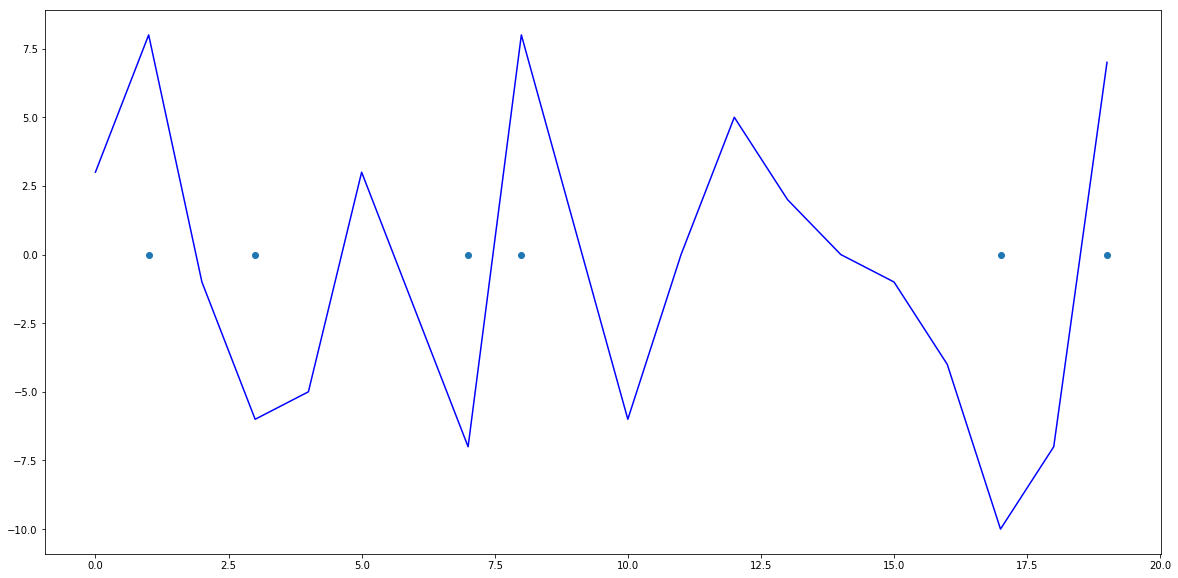

In [70]:
def test_get_maxi_mini():
    data = np.random.randint(-10, 10, size=20)
    print(np.argsort(data))
    print(data)
    print("----CONSOLE----")
    maxg, ming = get_maxi_mini(data)
    print("---------------")
    print(maxg, ming)
    max_q, min_q, locs = bi_order_sort(maxg, ming)
    print(max_q, min_q, locs)
    
    keypoints = [l[0] for l in locs]
    print(len(keypoints))
    plt.figure(figsize=(20, 10))
    plt.plot(data, 'b')
    plt.scatter(keypoints, np.full_like(keypoints, 0))
    plt.show()

test_get_maxi_mini()

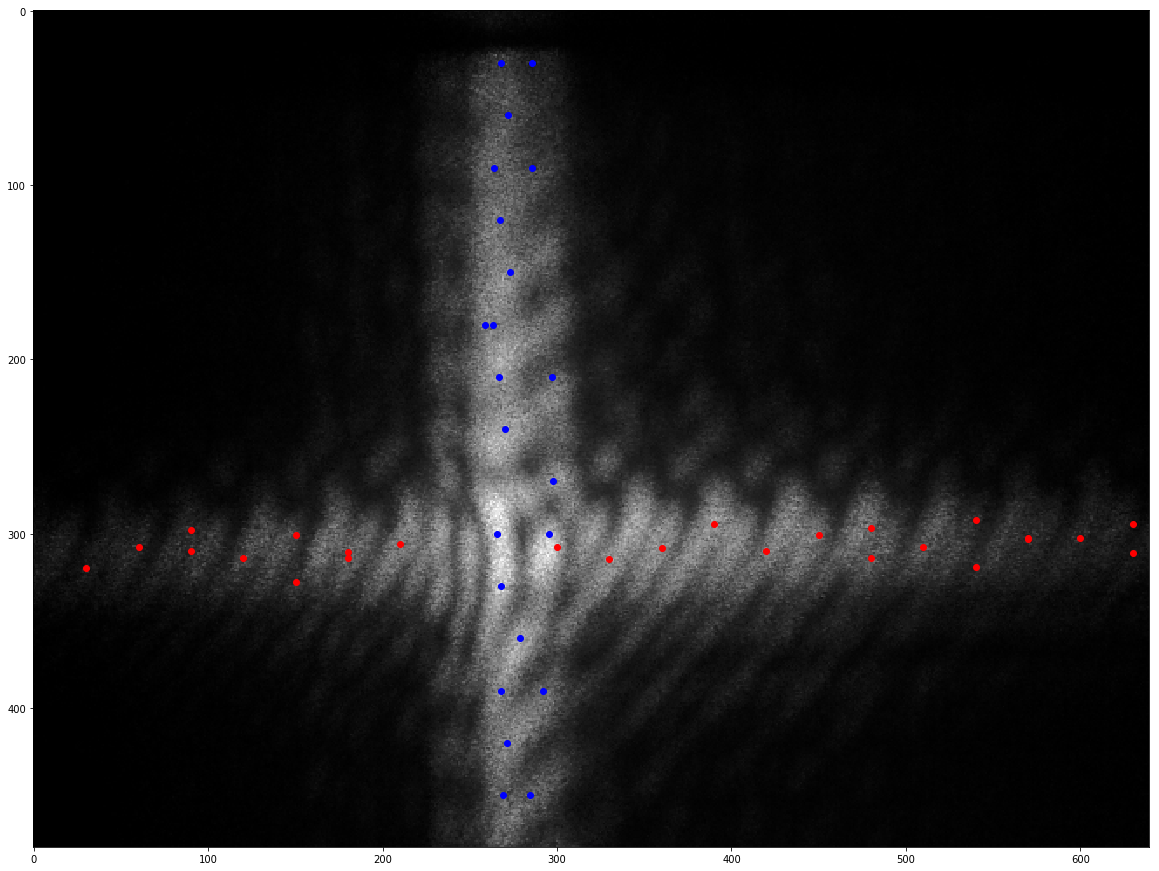

In [87]:
img1, centers1 = visualize_centers(img)

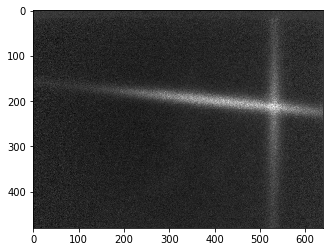

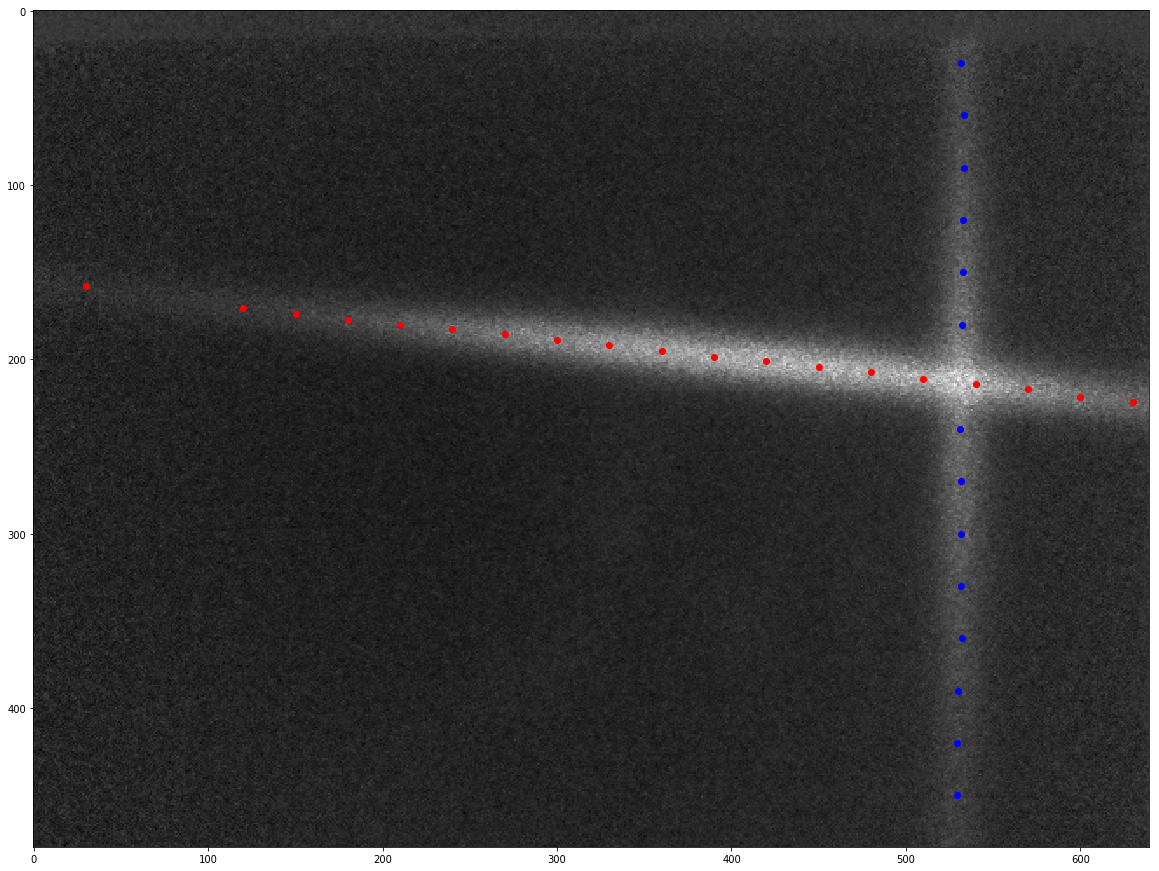

In [72]:
ambi_series = "ambi/img_1_{0}.png"
beam_series = "ambi/img_2_{0}.png"
ambin = ambi_series.format(1)
beamn = beam_series.format(1)
ambi = cv2.imread(ambin, 0)
beam = cv2.imread(beamn, 0)
res = image_diff(beam, ambi)
plt.imshow(res, cmap="gray")

img2, centers2 = visualize_centers(res)

### Deliverable 3: function model_fit(vb_points, hb_points) --> yield model

### model.get_center() --> x, y

#### Here we propose the following models:
#### Model 1: Brute Force
* Find points $p1, p2, p3, p4 \in border(img)$ to minimize $f(\vec p) = \sum_{x \in \mathcal{X}} min\{|x^T A\frac{p_3-p_1}{||p_3-p_1||_2}|, |x^T A\frac{p_4-p_2}{||p_4-p_2||_2}|\}$

#### Model 2, 3, 4: BasinHopping, DifferentialEvolution, Minimize
* Find parameter $p_0, v_1, v_2$ to minimize $f(p_0, v_1, v_2;\mathcal{X}) = \sum_{x \in \mathcal{X}} min\{|(x-p_0)^T Av_1|, |(x-p_0)^T A v_2|\}$


In [73]:
rotA = np.array([[0, -1],[1, 0]])
rotA_p = np.array([[0, 1], [-1, 0]])

def fourPointFunc(x, data):
    p1, p2, p3, p4 = x[:2], x[2:4], x[4:6], x[6:8]
    res = 0
    dir1 = rotA@(p3 - p1)
    dir2 = rotA@(p4 - p2)
    ndir1 = np.linalg.norm(dir1)
    ndir2 = np.linalg.norm(dir2)
    for d in data:
        d = np.array(d)
        res += minDist(d, dir1 / ndir1, dir2 / ndir2)
    return res

def pointDirFunc(x, data):
    # DATA MUST BE numpy.array
    p0, v1, v2 = x[:2], x[2:4], x[4:6]
    res = 0
    for d in data:
        diff = d - p0
        res += minDist(diff, v1, v2)
    return res  

def minDist(x, v1, v2):
    return min(abs(x @ v1), abs(x@v2))
    

class BasinHoppingModel:
    """Basin Hopping model for ransac"""
    def __init__(self, bounds, debug=False):
        self.debug = debug
        self.bounds = bounds
        
    def fit(self, data):
        x0, y0 = np.mean(data, axis=0)
        res = basinhopping(pointDirFunc, [x0, y0, 1, 0, 0, 1], minimizer_kwargs={'data': data})
        return res.x
    
    def get_error(self, data, model):
        err_per_point = [minDist(d-model[:2], model[2:4], model[4:6]) for d in data]
        return err_per_point
    

class LocalMinimizeModel:
    """Local Minimizer model for ransac"""
    def __init__(self, bounds, data_mean, debug=False):
        self.debug = debug
        self.r0, self.c0 = data_mean
        self.bounds = Bounds([0, 0, -np.inf, -np.inf, -np.inf, -np.inf],
                             [bounds[0], bounds[1], np.inf, np.inf, np.inf, np.inf])
        self.cons = [{'type': 'ineq', 'fun': lambda z: 1- np.linalg.norm(z[2:4])},
                     {'type': 'ineq', 'fun': lambda z: 1- np.linalg.norm(z[4:6])}]
        
    def fit(self, data):
        res = minimize(pointDirFunc, [self.r0, self.c0, 1, 0, 0, 1], 
                       args=(data), 
                       constraints=self.cons,
                       bounds=self.bounds)
        return res.x
    
    def get_error(self, data, model):
        err_per_point = np.array([minDist(d-model[:2], model[2:4], model[4:6]) for d in data])
        return err_per_point
    

class BruteForceModel:
    """Brute Force Model for ransac"""
    def __init__(self, debug=False):
        self.debug = debug
    
    def fit(self, data):
        pass
        
    def get_error( self, data, model):
        pass
    

class HoughTransformModel:
    """HoughTransform line model for ransac"""
    def __init__(self,input_columns,output_columns,debug=False):
        self.input_columns = input_columns
        self.output_columns = output_columns
        self.debug = debug
        
    def fit(self, data):
        A = data[:, self.input_columns].reshape(-1)
        B = data[:, self.output_columns].reshape(-1)
        x1, x2 = A[0], A[-1]
        y1, y2 = B[0], B[-1]
        theta0 = theta_pred(x1, y1, x2, y2)
        p0 = [theta0, np.mean(A) * np.cos(theta0) + np.mean(B) * np.sin(theta0)]
        pm, vm = curve_fit(hough_line, A, B, p0=p0)
        if pm[1] < 0:
            pm[1] = -pm[1]
            pm[0] -= HC
        angle = normalize_angle(pm[0])
        x = np.array([angle, pm[1]])
        return x
    
    def get_error( self, data, model):
        # Model: (angle, rho)
        A = data[:, self.input_columns].reshape(-1)
        B = data[:, self.output_columns].reshape(-1)
        B_fit = hough_line(A, model[0], model[1])
        err_per_point = (B-B_fit)**2 # sum squared error per row
        return err_per_point

    
def fitting(centers, model, n, k, t, d, db=False):
    ransac_fit, ransac_data = ransac(centers, model, n, k, t, d, return_all=True, debug=db)
    print(ransac_fit)
    return ransac_fit


In [74]:
# @source: https://scipy-cookbook.readthedocs.io/items/RANSAC.html
def ransac(data, model, n, k, t, d, debug=False, return_all=False):
    iterations = 0
    bestfit = None
    besterr = np.inf
    best_inlier_idxs = None
    while iterations < k:
        maybe_idxs, test_idxs = random_partition(n, data.shape[0])
        maybeinliers = data[maybe_idxs, :]
        test_points = data[test_idxs]
        maybemodel = model.fit(maybeinliers)
        test_err = model.get_error(test_points, maybemodel)
        also_idxs = test_idxs[test_err < t]  # select indices of rows with accepted points
        alsoinliers = data[also_idxs, :]
        if debug:
            print('total test ', len(test_err))
            print('test_err.min()', test_err.min())
            print('test_err.max()', test_err.max())
            print('np.mean(test_err)', np.mean(test_err))
            print('solution x0:{}, p1:{}, p2:{}'.format(maybemodel[:2], maybemodel[2:4], maybemodel[4:6]))
            print('iteration %d:len(alsoinliers) = %d' % (
                iterations, len(alsoinliers)))
        if len(alsoinliers) > d:
            betterdata = np.concatenate((maybeinliers, alsoinliers))
            bettermodel = model.fit(betterdata)
            better_errs = model.get_error(betterdata, bettermodel)
            thiserr = np.mean(better_errs)
            if thiserr < besterr:
                bestfit = bettermodel
                besterr = thiserr
                best_inlier_idxs = np.concatenate((maybe_idxs, also_idxs))
        iterations += 1
    if bestfit is None:
        raise ValueError("did not meet fit acceptance criteria")
    if return_all:
        return bestfit, {'inliers': best_inlier_idxs}
    else:
        return bestfit
    


def random_partition(n, n_data):
    """return n random rows of data (and also the other len(data)-n rows)"""
    all_idxs = np.arange(n_data)
    np.random.shuffle(all_idxs)
    idxs1 = all_idxs[:n]
    idxs2 = all_idxs[n:]
    return idxs1, idxs2

In [75]:
nsize = int(0.5 * len(centers1))
kiter = 200
thres = 10 ** (-6)
dval = int(0.3 * nsize)
print(nsize, kiter, thres, dval)
data1 = np.array(centers1)
print(len(data1))
fit1 = fitting(data1, LocalMinimizeModel(img1.shape, np.mean(data1, axis=0)), nsize, kiter, thres, dval, db=True)
nsize = int(0.5 * len(centers2))
dval = int(0.3 * nsize)
data2 = np.array(centers2)
print(nsize, kiter, thres, dval)
print(len(data2))
fit2 = fitting(data2, LocalMinimizeModel(img2.shape, np.mean(data2, axis=0)), nsize, kiter, thres, dval, db=True)

21 200 1e-06 6
42
total test  21
test_err.min() 9.921760424193483e-08
test_err.max() 1.432090588178862e-06
np.mean(test_err) 4.497268521598805e-07
solution x0:[211.02647345 331.82090851], p1:[-5.95013893e-09  1.19366563e-09], p2:[ 0.75992906 -0.25184846]
iteration 0:len(alsoinliers) = 18
total test  21
test_err.min() 8.970153704076982e-08
test_err.max() 2.600458422130698e-06
np.mean(test_err) 1.1533085248679835e-06
solution x0:[206.01838846 334.3885171 ], p1:[1.19332759e-08 5.69344826e-09], p2:[0.30365962 0.94010497]
iteration 1:len(alsoinliers) = 11
total test  21
test_err.min() 1.8583168455166762e-09
test_err.max() 1.5848076535716712e-06
np.mean(test_err) 4.6183032520043136e-07
solution x0:[214.28425809 331.99354281], p1:[-6.69913444e-09  6.57917244e-10], p2:[0.113225   0.09587765]
iteration 2:len(alsoinliers) = 18
total test  21
test_err.min() 5.8110315848918734e-08
test_err.max() 2.6478554768881915e-06
np.mean(test_err) 8.308164865930648e-07
solution x0:[211.61787321 332.83668362],

total test  21
test_err.min() 4.823956618599335e-07
test_err.max() 2.3846878668558294e-05
np.mean(test_err) 9.454764761065979e-06
solution x0:[211.35173659 332.3840632 ], p1:[ 2.53648608e-08 -9.31865046e-08], p2:[0.27596241 0.91245976]
iteration 33:len(alsoinliers) = 3
total test  21
test_err.min() 6.643001852407194e-09
test_err.max() 1.1712465195995916e-07
np.mean(test_err) 4.616789192728962e-08
solution x0:[212.0140903  331.89445979], p1:[ 0.24992099 -0.21825546], p2:[ 4.33713875e-10 -3.23410870e-10]
iteration 34:len(alsoinliers) = 21
total test  21
test_err.min() 2.9874797461840796e-08
test_err.max() 1.399918746852303e-06
np.mean(test_err) 4.521894724274791e-07
solution x0:[214.63736496 332.74750437], p1:[-0.99996868  0.00490021], p2:[-1.81185615e-09 -4.49743379e-09]
iteration 35:len(alsoinliers) = 19
total test  21
test_err.min() 1.7405178860386347e-07
test_err.max() 6.1943147734897005e-06
np.mean(test_err) 2.0254934224043955e-06
solution x0:[208.96883379 330.24696356], p1:[ 2.3949

total test  21
test_err.min() 7.195165735934077e-10
test_err.max() 2.406436195433722e-07
np.mean(test_err) 6.620994588138023e-08
solution x0:[214.01706655 331.08162825], p1:[-1.01712089e-09  7.97858454e-11], p2:[0.21244397 0.73019786]
iteration 64:len(alsoinliers) = 21
total test  21
test_err.min() 3.2170263234449936e-08
test_err.max() 6.904724080762478e-06
np.mean(test_err) 2.2396539472683907e-06
solution x0:[214.74957885 332.131762  ], p1:[ 2.68863083e-08 -1.34074207e-08], p2:[ 0.18611397 -0.98252812]
iteration 65:len(alsoinliers) = 7
total test  21
test_err.min() 6.118341328943848e-08
test_err.max() 1.6639333537854789e-06
np.mean(test_err) 4.276804581806367e-07
solution x0:[213.18472287 329.69436881], p1:[-7.54120262e-09  2.65216183e-09], p2:[-0.04838069 -0.31195054]
iteration 66:len(alsoinliers) = 18
total test  21
test_err.min() 2.3936577763516662e-08
test_err.max() 3.023079701900814e-06
np.mean(test_err) 1.2748858721334499e-06
solution x0:[214.07283522 329.53748891], p1:[-1.94369

total test  21
test_err.min() 6.834049958764276e-08
test_err.max() 5.347134112500279e-06
np.mean(test_err) 1.612469120576612e-06
solution x0:[213.84326688 331.75699493], p1:[ 2.12410695e-08 -7.72021345e-09], p2:[ 0.09215581 -0.57618478]
iteration 96:len(alsoinliers) = 10
total test  21
test_err.min() 1.640051786396557e-08
test_err.max() 2.06713907754086e-06
np.mean(test_err) 6.568377678517703e-07
solution x0:[210.29152475 331.66630186], p1:[-1.61227589e-09 -6.64939875e-09], p2:[-0.09668725 -0.48877208]
iteration 97:len(alsoinliers) = 13
total test  21
test_err.min() 4.6137045076484926e-07
test_err.max() 7.339915937281824e-05
np.mean(test_err) 1.5529045146964665e-05
solution x0:[214.85900884 329.9305012 ], p1:[-0.33344976  0.04458379], p2:[-2.95073756e-07  9.78448535e-08]
iteration 98:len(alsoinliers) = 1
total test  21
test_err.min() 2.838839595600443e-09
test_err.max() 1.945929366651271e-06
np.mean(test_err) 7.165441151741719e-07
solution x0:[214.58930224 332.22686154], p1:[-1.6599538

total test  21
test_err.min() 4.636268840913814e-08
test_err.max() 2.8360206246230625e-06
np.mean(test_err) 9.87135093913488e-07
solution x0:[207.2675307  325.93641593], p1:[-1.16999101e-08 -1.49264049e-09], p2:[-0.19640474 -0.71197461]
iteration 129:len(alsoinliers) = 12
total test  21
test_err.min() 8.345159343367747e-09
test_err.max() 2.4885295024634567e-06
np.mean(test_err) 7.82761817088371e-07
solution x0:[213.15374572 328.8818418 ], p1:[ 1.27727896e-09 -8.73718677e-09], p2:[ 0.97434596 -0.16160338]
iteration 130:len(alsoinliers) = 15
total test  21
test_err.min() 1.3395050732945213e-07
test_err.max() 6.392688688742254e-06
np.mean(test_err) 2.1812463490606127e-06
solution x0:[208.56101424 333.90500792], p1:[-9.80518905e-09 -1.80799740e-08], p2:[-0.00412035 -0.12438648]
iteration 131:len(alsoinliers) = 7
total test  21
test_err.min() 4.480977813423978e-08
test_err.max() 1.8563596221780256e-06
np.mean(test_err) 4.4740597719046343e-07
solution x0:[211.71478769 335.18548801], p1:[-7.6

total test  21
test_err.min() 6.174235051090467e-08
test_err.max() 3.34829807295487e-06
np.mean(test_err) 1.2401616494450234e-06
solution x0:[214.11095568 331.58476835], p1:[-1.87742694e-08 -2.49566745e-09], p2:[0.94449096 0.27373025]
iteration 160:len(alsoinliers) = 10
total test  21
test_err.min() 8.451658030025732e-08
test_err.max() 7.888333903571257e-06
np.mean(test_err) 2.66869732434307e-06
solution x0:[206.35093678 329.60225679], p1:[-3.21049438e-08  1.62115027e-09], p2:[-0.03102811 -0.79947441]
iteration 161:len(alsoinliers) = 6
total test  21
test_err.min() 2.8196893132618086e-08
test_err.max() 3.9338334976689335e-06
np.mean(test_err) 9.830097505821149e-07
solution x0:[212.01587605 332.0824284 ], p1:[-1.65279714e-08  4.99814769e-11], p2:[ 0.80944061 -0.58309717]
iteration 162:len(alsoinliers) = 15
total test  21
test_err.min() 2.176235467273852e-08
test_err.max() 1.960492958494299e-05
np.mean(test_err) 4.530164886640943e-06
solution x0:[193.51603419 339.723522  ], p1:[ 7.265954

total test  21
test_err.min() 7.98568546680035e-08
test_err.max() 1.8152647430182566e-06
np.mean(test_err) 8.207288355447642e-07
solution x0:[211.39991939 340.74160299], p1:[-7.42725071e-09 -3.58461727e-09], p2:[-0.08075877 -0.59997159]
iteration 190:len(alsoinliers) = 12
total test  21
test_err.min() 1.244985293338396e-07
test_err.max() 6.032090854952375e-06
np.mean(test_err) 2.057598743129943e-06
solution x0:[216.65788481 334.74244364], p1:[-3.81850722e-09  2.10432132e-08], p2:[0.24631865 0.79115457]
iteration 191:len(alsoinliers) = 4
total test  21
test_err.min() 1.1747612855104266e-07
test_err.max() 1.210835164990852e-05
np.mean(test_err) 3.684323076795294e-06
solution x0:[215.27986506 331.41692304], p1:[-1.39126735e-09  4.07704909e-08], p2:[0.26634786 0.56034414]
iteration 192:len(alsoinliers) = 5
total test  21
test_err.min() 2.9908981987203484e-08
test_err.max() 2.3276262747598997e-06
np.mean(test_err) 6.870150576290967e-07
solution x0:[213.04572431 331.91604785], p1:[-2.9987032

total test  17
test_err.min() 8.198691813294828e-10
test_err.max() 8.136275501214901e-07
np.mean(test_err) 3.073217672727418e-07
solution x0:[214.77729704 431.14366547], p1:[-1.03535654e-09  2.17512278e-09], p2:[-0.31872447 -0.94643343]
iteration 23:len(alsoinliers) = 17
total test  17
test_err.min() 5.249268371362679e-09
test_err.max() 7.691233986508419e-07
np.mean(test_err) 2.385135325467694e-07
solution x0:[209.61751131 433.44948337], p1:[ 3.81559868e-09 -8.53603486e-10], p2:[0.80745668 0.31441177]
iteration 24:len(alsoinliers) = 17
total test  17
test_err.min() 2.2875199779747927e-07
test_err.max() 1.042702946428385e-05
np.mean(test_err) 3.990598443178317e-06
solution x0:[205.75244856 438.24538334], p1:[-0.64627671 -0.15013879], p2:[-2.42825587e-08 -2.26936053e-08]
iteration 25:len(alsoinliers) = 4
total test  17
test_err.min() 4.275910315043452e-07
test_err.max() 8.47351111404347e-06
np.mean(test_err) 3.386618186638229e-06
solution x0:[201.4591672  430.71831006], p1:[-3.76116019e-

total test  17
test_err.min() 1.644170680941089e-07
test_err.max() 7.16102246369235e-06
np.mean(test_err) 1.8833852679628828e-06
solution x0:[212.90290572 431.83890014], p1:[-3.17598320e-08  3.78478537e-09], p2:[-0.40892276 -0.61703872]
iteration 57:len(alsoinliers) = 10
total test  17
test_err.min() 1.0608198586557101e-07
test_err.max() 3.83909155264767e-05
np.mean(test_err) 8.372378421284443e-06
solution x0:[216.55508289 432.53979476], p1:[-1.87973881e-07  3.35522280e-08], p2:[-0.13342115 -0.61706272]
iteration 58:len(alsoinliers) = 3
total test  17
test_err.min() 4.4012485981965165e-07
test_err.max() 1.338252985815898e-05
np.mean(test_err) 4.811458525104914e-06
solution x0:[213.47579654 430.8918646 ], p1:[-5.81897958e-08  3.86642132e-09], p2:[ 0.2182007  -0.90163609]
iteration 59:len(alsoinliers) = 4
total test  17
test_err.min() 2.285470146766799e-08
test_err.max() 1.5195663390159719e-06
np.mean(test_err) 3.920018241883511e-07
solution x0:[248.1830744  417.02785542], p1:[-6.1768711

total test  17
test_err.min() 7.584299047862427e-09
test_err.max() 8.570786491040783e-07
np.mean(test_err) 3.930954866865939e-07
solution x0:[212.63357629 431.83850392], p1:[-0.33471953 -0.77339944], p2:[ 3.31312072e-09 -2.58433286e-09]
iteration 90:len(alsoinliers) = 17
total test  17
test_err.min() 2.0790935321311063e-08
test_err.max() 8.719388801881934e-06
np.mean(test_err) 2.4702854438245096e-06
solution x0:[205.87951496 436.39090442], p1:[-4.27557573e-08  4.69204613e-09], p2:[ 0.54531568 -0.64088567]
iteration 91:len(alsoinliers) = 9
total test  17
test_err.min() 1.0534333404135603e-07
test_err.max() 2.253141039962077e-06
np.mean(test_err) 5.523008101108678e-07
solution x0:[213.70167848 429.77730345], p1:[-9.98636635e-09  1.07054586e-09], p2:[-0.09682619 -0.28230874]
iteration 92:len(alsoinliers) = 13
total test  17
test_err.min() 2.5386992503103304e-08
test_err.max() 3.12724932141848e-06
np.mean(test_err) 1.463692043314376e-06
solution x0:[212.04394994 432.34927716], p1:[ 1.57645

test_err.max() 4.099706803625681e-06
np.mean(test_err) 1.5976126924370633e-06
solution x0:[204.42117625 437.49485197], p1:[-0.11755863 -0.55834444], p2:[-2.19223571e-09  1.31464450e-08]
iteration 120:len(alsoinliers) = 7
total test  17
test_err.min() 4.2734715422920105e-07
test_err.max() 1.763631660878628e-05
np.mean(test_err) 5.4753508115852435e-06
solution x0:[212.26806063 431.85527441], p1:[-7.78965857e-08  9.04655905e-09], p2:[-0.00268121  0.061992  ]
iteration 121:len(alsoinliers) = 9
total test  17
test_err.min() 1.2424062392883781e-08
test_err.max() 5.758128449120539e-07
np.mean(test_err) 1.9333799310004664e-07
solution x0:[212.37660951 431.5330497 ], p1:[ 4.24143621e-10 -1.49160153e-09], p2:[-0.26635412 -0.22063636]
iteration 122:len(alsoinliers) = 17
total test  17
test_err.min() 2.3925357766215226e-07
test_err.max() 1.0265108283207146e-05
np.mean(test_err) 3.316146492474164e-06
solution x0:[206.74104316 421.44428294], p1:[ 4.70343247e-08 -1.77235373e-08], p2:[ 0.12199516 -0.2

iteration 151:len(alsoinliers) = 9
total test  17
test_err.min() 4.185305040037574e-08
test_err.max() 1.4155640279880355e-06
np.mean(test_err) 5.006924436306604e-07
solution x0:[210.53185402 433.31001019], p1:[-0.36675351  0.02032712], p2:[ 6.35550028e-09 -2.72881056e-09]
iteration 152:len(alsoinliers) = 14
total test  17
test_err.min() 3.5085152752365267e-06
test_err.max() 0.00014441556007876327
np.mean(test_err) 6.0717599455793355e-05
solution x0:[212.75967542 430.57180984], p1:[-0.98754177 -0.10884599], p2:[-6.21938215e-07  3.17131733e-08]
iteration 153:len(alsoinliers) = 0
total test  17
test_err.min() 7.20538465597652e-08
test_err.max() 1.3732101340455208e-05
np.mean(test_err) 3.3397634483008794e-06
solution x0:[211.7192939  433.41976841], p1:[-0.07571289 -0.99296661], p2:[-6.80890754e-08  4.69313152e-09]
iteration 154:len(alsoinliers) = 7
total test  17
test_err.min() 5.087314231746713e-08
test_err.max() 2.1514962866781786e-06
np.mean(test_err) 7.239967840895979e-07
solution x0:[

total test  17
test_err.min() 5.716330680178011e-08
test_err.max() 3.230723465483278e-06
np.mean(test_err) 1.1886145943260784e-06
solution x0:[211.67841856 438.00801675], p1:[-0.19061245 -0.96540589], p2:[-4.16575683e-09 -7.36900126e-09]
iteration 186:len(alsoinliers) = 9
total test  17
test_err.min() 4.543461795706811e-08
test_err.max() 2.676133444382414e-06
np.mean(test_err) 9.59326493204017e-07
solution x0:[210.00945911 448.66787763], p1:[-0.4739602   0.62639792], p2:[-1.62482630e-08 -2.86384826e-09]
iteration 187:len(alsoinliers) = 9
total test  17
test_err.min() 1.848846823685154e-08
test_err.max() 1.1284718240405135e-06
np.mean(test_err) 4.258139354144761e-07
solution x0:[213.71404102 431.60699306], p1:[-0.34568966 -0.90828118], p2:[ 4.77714395e-09 -2.50880239e-09]
iteration 188:len(alsoinliers) = 16
total test  17
test_err.min() 3.246461564583301e-07
test_err.max() 3.0013238629229173e-06
np.mean(test_err) 1.0505601057646278e-06
solution x0:[213.99947672 432.5092121 ], p1:[-8.035

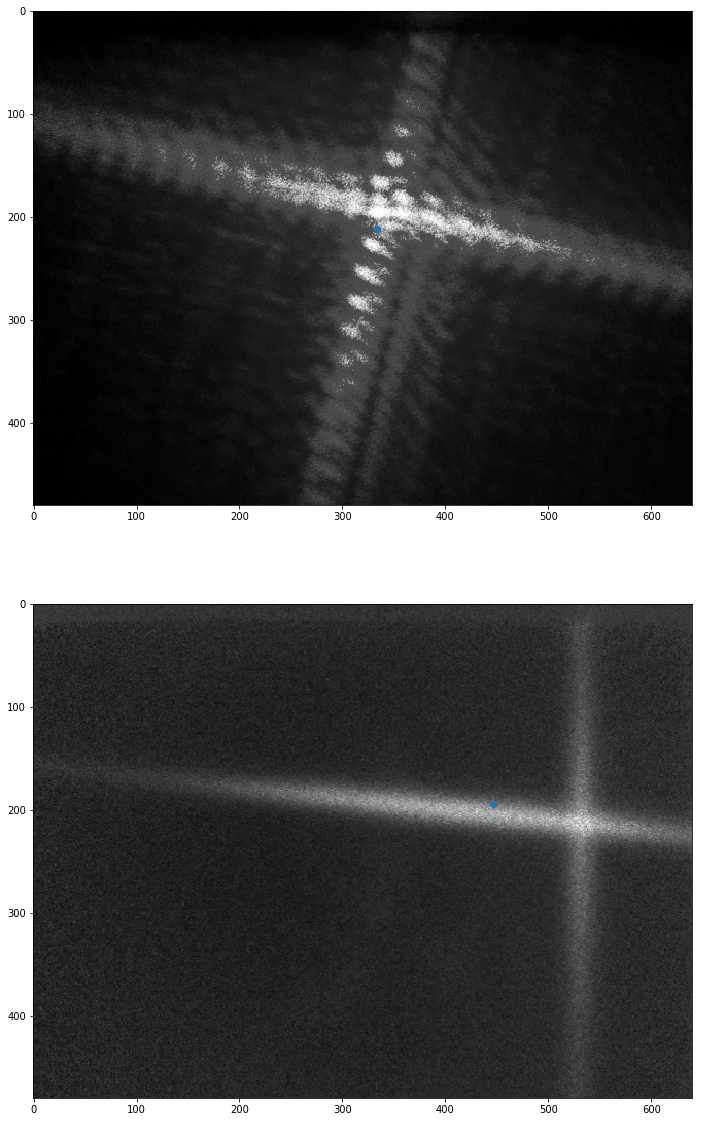

In [76]:
plt.figure(figsize=(20, 20))
plt.subplot(211)
plt.imshow(img1, cmap='gray')
plt.scatter([fit1[1]], [fit1[0]])
plt.subplot(212)
plt.imshow(img2, cmap='gray')
plt.scatter([fit2[1]], [fit2[0]])
plt.show()

19 23 4 4 10 13
total test  15
test_err.min() 1.8605434033402535
test_err.max() 513947.85263709736
np.mean(test_err) 41385.56524803828
solution x0:[2.43046962e-01 3.85451487e+02], p1:[], p2:[]
iteration 0:len(alsoinliers) = 10
total test  15
test_err.min() 0.12807341832255664
test_err.max() 544804.8495581767
np.mean(test_err) 44754.649393345455
solution x0:[2.30030713e-01 3.79873075e+02], p1:[], p2:[]
iteration 1:len(alsoinliers) = 11
total test  15
test_err.min() 7.518078625609052
test_err.max() 551032.9550442309
np.mean(test_err) 44395.51520159769
solution x0:[2.32417252e-01 3.82805532e+02], p1:[], p2:[]
iteration 2:len(alsoinliers) = 11
total test  15
test_err.min() 10.732508500865297
test_err.max() 569867.3591129141
np.mean(test_err) 46541.295295876465
solution x0:[2.24638848e-01 3.79168403e+02], p1:[], p2:[]
iteration 3:len(alsoinliers) = 11
total test  15
test_err.min() 306.1797802659136
test_err.max() 61725.822401157035
np.mean(test_err) 15512.284127946408
solution x0:[  1.20858

/Users/albertqu/Documents/7.Research/PEER Research/bridge_settlement/img_rec_module/sig_proc.py:188: RuntimeWarning: divide by zero encountered in true_divide
  return (rho - x * cos(theta)) / sin(theta)
/anaconda3/lib/python3.6/site-packages/scipy/optimize/minpack.py:794: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


15
test_err.min() 143.25518379086958
test_err.max() 1101710.846601646
np.mean(test_err) 88604.2239771752
solution x0:[1.66901040e-01 3.78935071e+02], p1:[], p2:[]
iteration 93:len(alsoinliers) = 5
total test  15
test_err.min() 0.024172197294582597
test_err.max() 597142.9187108558
np.mean(test_err) 48803.50948421156
solution x0:[2.19221487e-01 3.78486568e+02], p1:[], p2:[]
iteration 94:len(alsoinliers) = 11
total test  15
test_err.min() 4.685866239464852
test_err.max() 63218.262101286135
np.mean(test_err) 18422.473745157044
solution x0:[  1.78001369 197.41831002], p1:[], p2:[]
iteration 95:len(alsoinliers) = 3
total test  15
test_err.min() 13.776777088979415
test_err.max() 663027.3826968261
np.mean(test_err) 55020.508000695685
solution x0:[2.04876164e-01 3.74542029e+02], p1:[], p2:[]
iteration 96:len(alsoinliers) = 10
total test  15
test_err.min() 11.01153633665409
test_err.max() 647045.7720465634
np.mean(test_err) 51782.46469418036
solution x0:[2.12839813e-01 3.79667771e+02], p1:[], p2

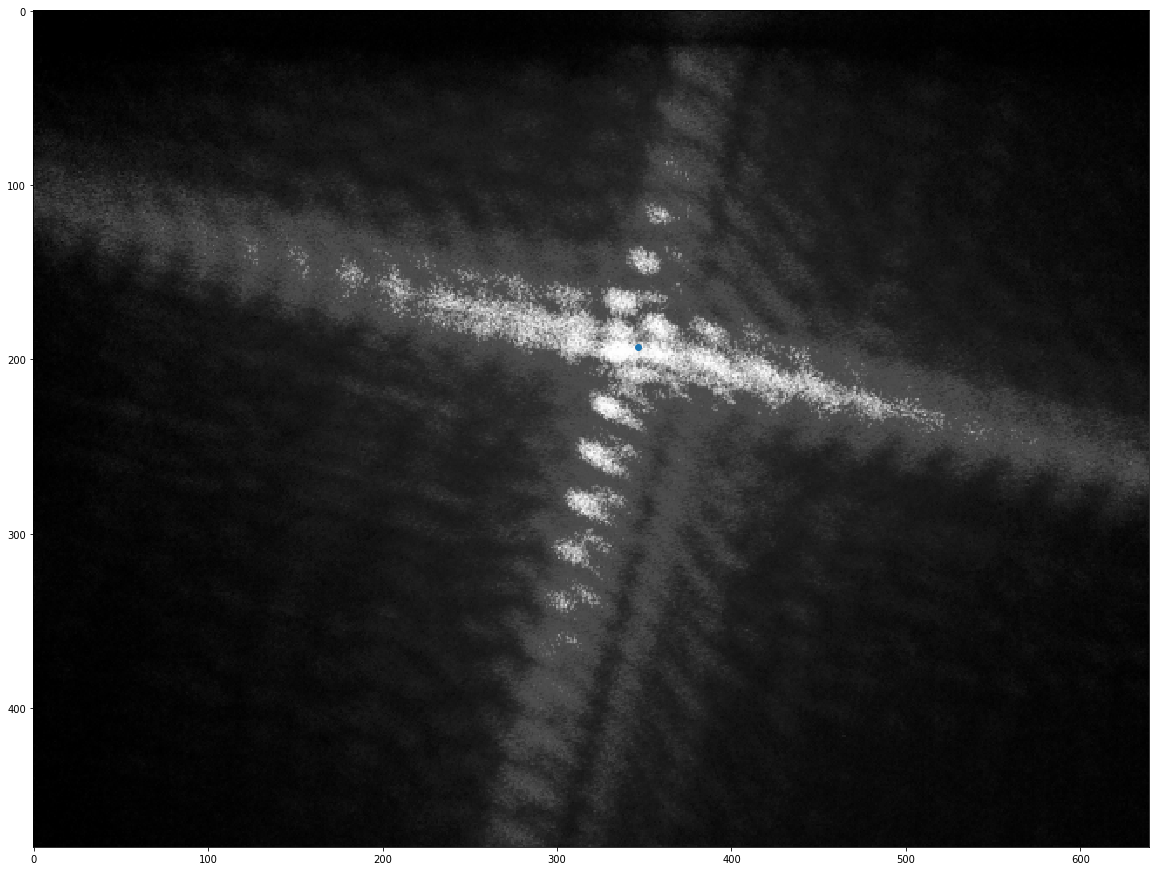

14 19 4 4 7 10
total test  10
test_err.min() 22.625791362683003
test_err.max() 61259.32148169313
np.mean(test_err) 9222.30848173457
solution x0:[1.25263961e-02 5.35026667e+02], p1:[], p2:[]
iteration 0:len(alsoinliers) = 5
total test  10
test_err.min() 1015.9414559030068
test_err.max() 82749.20708071554
np.mean(test_err) 23883.691597257188
solution x0:[8.00122681e-03 5.32700427e+02], p1:[], p2:[]
iteration 1:len(alsoinliers) = 2
total test  10
test_err.min() 25.26322126253583
test_err.max() 67021.68203572478
np.mean(test_err) 11199.190078664922
solution x0:[1.30768519e-02 5.35324464e+02], p1:[], p2:[]
iteration 2:len(alsoinliers) = 3
total test  10
test_err.min() 10.399520097703617
test_err.max() 46319.731860857675
np.mean(test_err) 8017.835440413493
solution x0:[1.03464487e-02 5.33608118e+02], p1:[], p2:[]
iteration 3:len(alsoinliers) = 7
total test  10
test_err.min() 34.63725242441228
test_err.max() 64093.11440448617
np.mean(test_err) 10077.084939264148
solution x0:[1.61391211e-02 5.

np.mean(test_err) 1.8247438800159805
solution x0:[  1.68025602 154.01323753], p1:[], p2:[]
iteration 16:len(alsoinliers) = 15
total test  15
test_err.min() 0.0003267341035970773
test_err.max() 9.049358676334476
np.mean(test_err) 0.8623091795499739
solution x0:[  1.67462282 156.91243187], p1:[], p2:[]
iteration 17:len(alsoinliers) = 15
total test  15
test_err.min() 0.001319835872671901
test_err.max() 10.618966288002452
np.mean(test_err) 0.9692018148897809
solution x0:[  1.67475005 157.15562099], p1:[], p2:[]
iteration 18:len(alsoinliers) = 15
total test  15
test_err.min() 0.00109586778382714
test_err.max() 12.830052109029118
np.mean(test_err) 1.2228053765431568
solution x0:[  1.67280945 157.56722734], p1:[], p2:[]
iteration 19:len(alsoinliers) = 15
total test  15
test_err.min() 0.004840917825621177
test_err.max() 9.136398335305731
np.mean(test_err) 0.9387226549812888
solution x0:[  1.6741419  156.94913812], p1:[], p2:[]
iteration 20:len(alsoinliers) = 15
total test  15
test_err.min() 0.

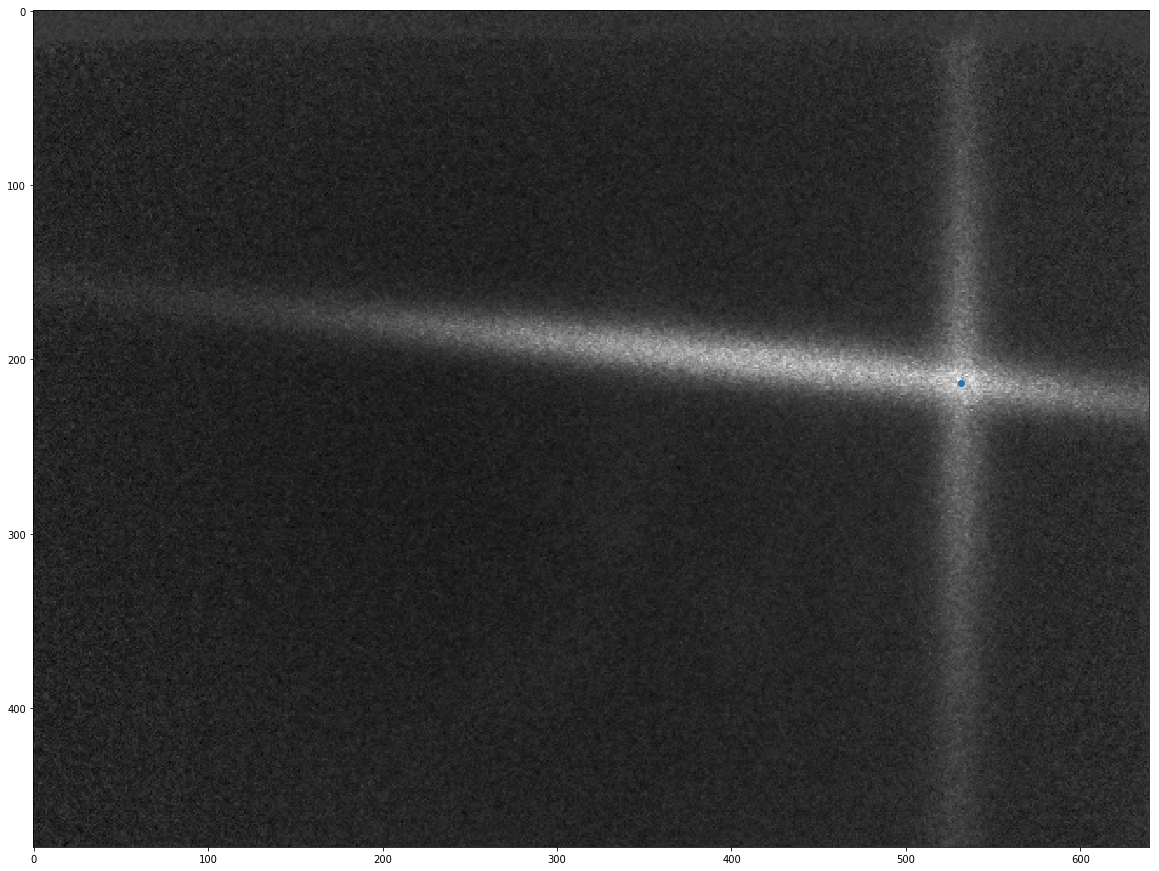

In [77]:
def center_detect_fine(img, kiter=200, thres=3000, n_size=4, d_ratio=0.7, debug=False, visual=False):
    # Data Collection
    centers_v, centers_h = gather_all(img)
    datav, datah = np.array(centers_v), np.array(centers_h)
    
    # Parameter Setting
    lenv, lenh = len(centers_v), len(centers_h)
    nsizev, nsizeh = n_size, n_size
    dvalv, dvalh = int(d_ratio * (lenv-nsizev)), int(d_ratio * (lenh-nsizeh))
    print(lenv, lenh, nsizev, nsizeh, dvalv, dvalh)

    # Data Fitting and Center Extraction
    houghmodel = HoughTransformModel((1), (0))
    fitv = fitting(datav, houghmodel, nsizev, kiter, thres, dvalv, db=debug)
    fith = fitting(datah, houghmodel, nsizeh, kiter, thres, dvalh, db=debug)
    line11, line12 = HoughLine(fitv[0], fitv[1]), HoughLine(fith[0], fith[1])
    ct = HoughLine.intersect(line11, line12)
    
    # Visualization
    if visual:
        plt.figure(figsize=(20, 20))
        plt.imshow(img, cmap='gray')
        plt.scatter([ct[0]], [ct[1]])
        plt.show()
        
    return ct

y1 = center_detect_fine(img1, kiter=100, thres=3000, d_ratio=0.7, debug=True, visual=True)
y2 = center_detect_fine(img2, kiter=100, thres=3000, d_ratio=0.7, debug=True, visual=True)

In [78]:
prob1 = cv2.imread(calib_series.format(i), 0)

22 27 4 4 9 11
[  0.4016721  377.71882843]
[  1.5536612  312.04227444]

/Users/albertqu/Documents/7.Research/PEER Research/bridge_settlement/img_rec_module/sig_proc.py:188: RuntimeWarning: divide by zero encountered in true_divide
  return (rho - x * cos(theta)) / sin(theta)
/anaconda3/lib/python3.6/site-packages/scipy/optimize/minpack.py:794: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/Users/albertqu/Documents/7.Research/PEER Research/bridge_settlement/img_rec_module/sig_proc.py:188: RuntimeWarning: invalid value encountered in true_divide
  return (rho - x * cos(theta)) / sin(theta)
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in less
  del sys.path[0]


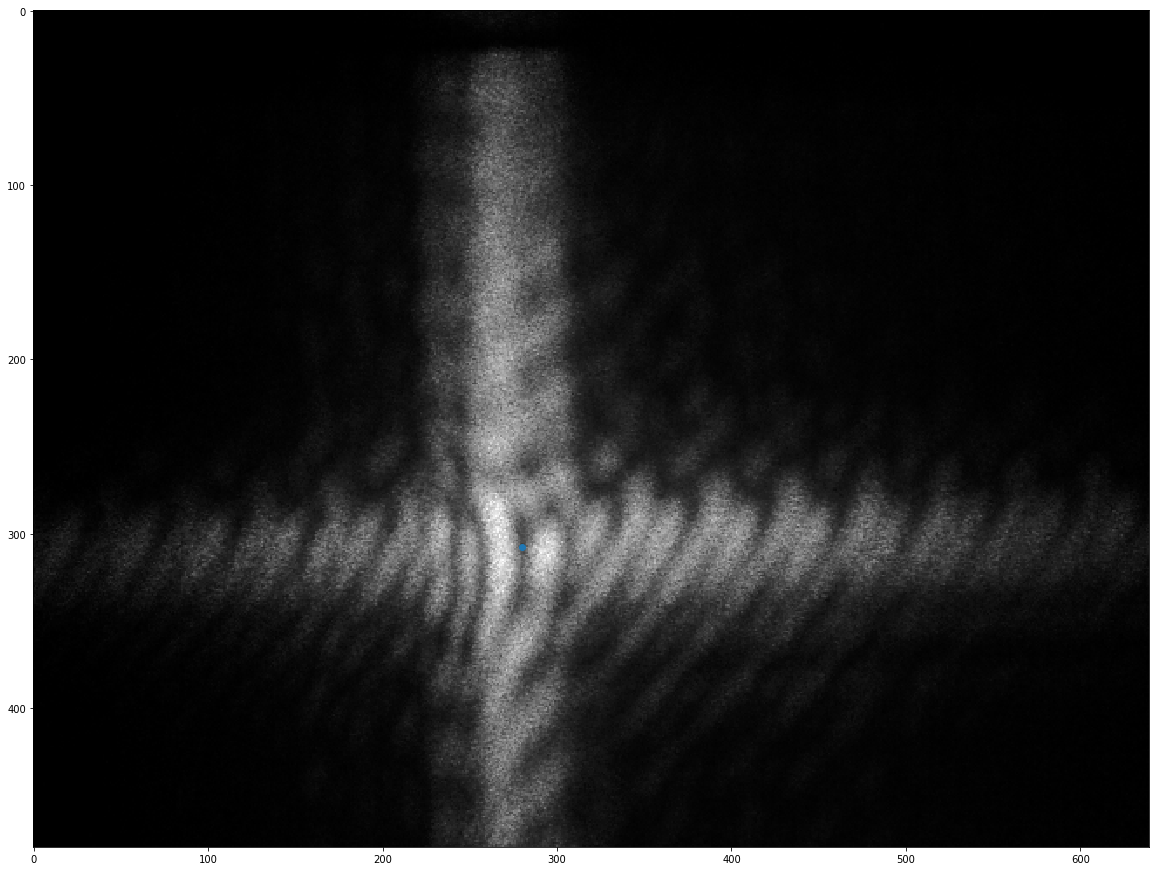

Done for 113
22 26 4 4 9 11


ValueError: did not meet fit acceptance criteria

In [79]:
for i in range(113, 150):
    img = cv2.imread(calib_series.format(i), 0)
    x, y = center_detect_fine(img, thres=10000, d_ratio=0.5, visual=True)
    print('Done for', i)
for i in range(90, 96):
    img = cv2.imread(skewed_series.format(i), 0)
    x, y = center_detect_fine(img, visual=True)

### Deliverable 4: Exploration of HoughTransform

16 28


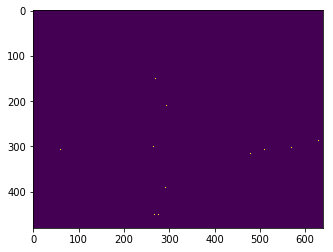

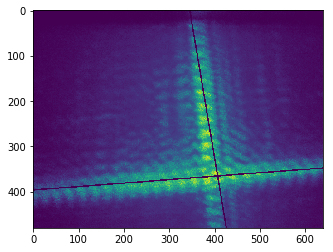

In [131]:
img1 = cv2.imread(skewed_series.format(93), 0)
centers_v, centers_h = gather_all(img1)
centpointsv = np.zeros_like(img1, dtype=np.uint8)
centpointsh = np.zeros_like(img1, dtype=np.uint8)
for r, c in centers_v:
    centpointsv[int(r)][int(c)] = 255
for r, c in centers_h:
    centpointsh[int(r)][int(c)] = 255
    
print(len(centers_v), len(centers_h))
plt.imshow(centpoints)
plt.show()
linesv = cv2.HoughLines(centpointsv, 0.5, 0.005, 1)
linesh = cv2.HoughLines(centpointsh, 0.5, 0.005, 1)
for rho,theta in linesv[0]:
    a = np.cos(theta)
    b = np.sin(theta)
    x0 = a*rho
    y0 = b*rho
    x1 = int(x0 + 1000*(-b))
    y1 = int(y0 + 1000*(a))
    x2 = int(x0 - 1000*(-b))
    y2 = int(y0 - 1000*(a))

    cv2.line(img1,(x1,y1),(x2,y2),(0,0,255),2)

for rho,theta in linesh[0]:
    a = np.cos(theta)
    b = np.sin(theta)
    x0 = a*rho
    y0 = b*rho
    x1 = int(x0 + 1000*(-b))
    y1 = int(y0 + 1000*(a))
    x2 = int(x0 - 1000*(-b))
    y2 = int(y0 - 1000*(a))

    cv2.line(img1,(x1,y1),(x2,y2),(0,0,255),2)

plt.figure()
plt.imshow(img1)
plt.show()